In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from process_movella import load_movella, get_position
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FFMpegWriter

In [2]:
IN_DIR = Path("uploads_new/")
OUT_DIR = Path("out")

# make the output directory if it does not exit
if not OUT_DIR.exists():
    OUT_DIR.mkdir()

In [3]:
# Problem constants
d = 83./100     # m, hoop diameter
r = d/2         # m, hoop radius
m = 0.25        # kg, mass of hoop
g = 9.81        # m/s^2, gravitational acceleration

# Time setup
f = 120         # Hz, sampling frequency
dt = 1 / f      # s, sample duration

# Inertias in corotational basis
Ixx = 0.5*m*r**2
Iyy = 0.5*m*r**2
Izz = m*r**2

In [4]:
# Reading sensor data

# OL: left side of hoop
# OR: right side of hoop
# IT: on hip, above hoop (on waist belt)
# IB: on hip, below hoop (in pocket)
OL_hoop_file = list(IN_DIR.glob("OL_20250717_164035*.csv"))[0]
OR_hoop_file = list(IN_DIR.glob("OR_20250717_164035*.csv"))[0]
IT_hoop_file = list(IN_DIR.glob("IT_20250717_164035*.csv"))[0]
# IB_hoop_file = list(IN_DIR.glob("IB_20250717_164035*.csv"))[0]

OL_hoop_data = load_movella(OL_hoop_file, lead_time=4)
OR_hoop_data = load_movella(OR_hoop_file, lead_time=4)
IT_hoop_data = load_movella(IT_hoop_file, lead_time=4)
# IB_hoop_data = load_movella(IB_hoop_file, lead_time=4)

time, OL_accel_x, OL_accel_y, OL_accel_z, OL_phi, OL_theta, OL_psi, OL_wx, OL_wy, OL_wz = OL_hoop_data.T
_, OR_accel_x, OR_accel_y, OR_accel_z, OR_phi, OR_theta, OR_psi, OR_wx, OR_wy, OR_wz = OR_hoop_data.T
_, IT_accel_x, IT_accel_y, IT_accel_z, IT_phi, IT_theta, IT_psi, OL_wx, OL_wy, OL_wz = IT_hoop_data.T
# _, IB_accel_x, IB_accel_y, IB_accel_z, IB_phi, IB_theta, IB_psi = IB_hoop_data.T



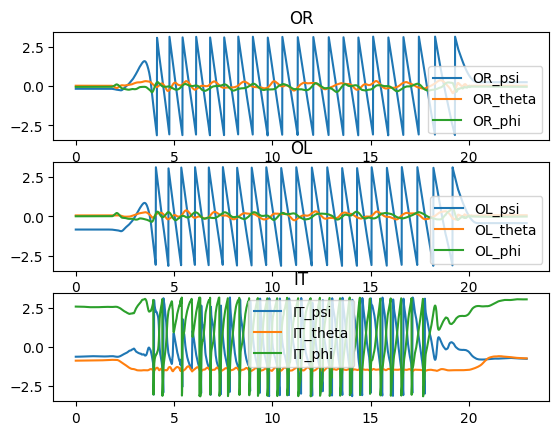

In [5]:
# Plotting raw euler angle data
# re: raw euler
fig_re, ax_re = plt.subplots(3)  # Creates a 3x1 grid of Axes

ax_re[0].set_title('OR')
ax_re[0].plot(time, OR_psi, label='OR_psi')
ax_re[0].plot(time, OR_theta, label='OR_theta')
ax_re[0].plot(time, OR_phi, label='OR_phi')
ax_re[0].legend()

ax_re[1].set_title('OL')
ax_re[1].plot(time, OL_psi, label='OL_psi')
ax_re[1].plot(time, OL_theta, label='OL_theta')
ax_re[1].plot(time, OL_phi, label='OL_phi')
ax_re[1].legend()

ax_re[2].set_title('IT')
ax_re[2].plot(time, IT_psi, label='IT_psi')
ax_re[2].plot(time, IT_theta, label='IT_theta')
ax_re[2].plot(time, IT_phi, label='IT_phi')
ax_re[2].legend()

Why does phiIT go below the phi limit?

In [6]:
print(np.min(IT_psi))
print(np.max(IT_psi))

print(np.min(IT_theta))
print(np.max(IT_theta))

print(np.min(IT_phi))
print(np.max(IT_phi))


-3.1289745963449977
3.1407716010257216
-1.5652613459433304
-0.5870109714190394
-3.1404296511417558
3.1374770044411844


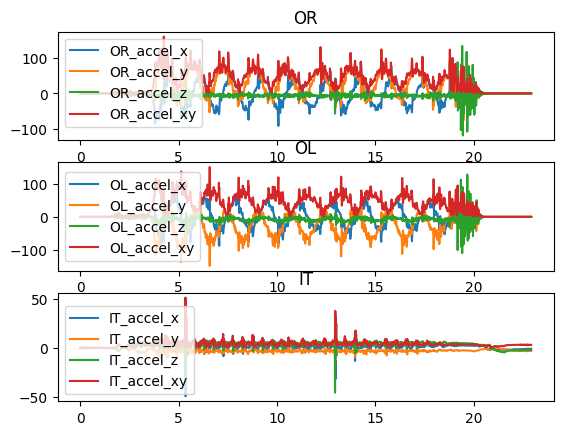

In [7]:
# Plotting raw acceleration data
# ra: raw accelerations
fig_ra, ax_ra = plt.subplots(3)  # Creates a 3x1 grid of Axes

ax_ra[0].set_title('OR')
ax_ra[0].plot(time, OR_accel_x, label='OR_accel_x')
ax_ra[0].plot(time, OR_accel_y, label='OR_accel_y')
ax_ra[0].plot(time, OR_accel_z, label='OR_accel_z')
OR_accel_xy = np.sqrt(OR_accel_x**2+OR_accel_y**2)
ax_ra[0].plot(time, OR_accel_xy, label='OR_accel_xy')
ax_ra[0].legend()

ax_ra[1].set_title('OL')
ax_ra[1].plot(time, OL_accel_x, label='OL_accel_x')
ax_ra[1].plot(time, OL_accel_y, label='OL_accel_y')
ax_ra[1].plot(time, OL_accel_z, label='OL_accel_z')
OL_accel_xy = np.sqrt(OL_accel_x**2+OL_accel_y**2)
ax_ra[1].plot(time, OL_accel_xy, label='OL_accel_xy')
ax_ra[1].legend()

ax_ra[2].set_title('IT')
ax_ra[2].plot(time, IT_accel_x, label='IT_accel_x')
ax_ra[2].plot(time, IT_accel_y, label='IT_accel_y')
ax_ra[2].plot(time, IT_accel_z, label='IT_accel_z')
IT_accel_xy = np.sqrt(IT_accel_x**2+IT_accel_y**2)
ax_ra[2].plot(time, IT_accel_xy, label='IT_accel_xy')
ax_ra[2].legend()

At the minimum value of az, that's the point when the sensor is being pushed up. Both sensors should read the same signal, but shifted. The shift can be adjusted by aligning the local minimza of az.

In [8]:
# Fixed basis
E1 = np.array([1,0,0])
E2 = np.array([0,1,0])
E3 = np.array([0,0,1])

def get_fixed_frame_acceleration(ax, ay, az, psi,theta,phi):

    n = np.size(psi)

    e1p = np.zeros((3,n))
    e2p = np.zeros((3,n))
    e3p = np.zeros((3,n))

    e1pp = np.zeros((3,n))
    e2pp = np.zeros((3,n))
    e3pp = np.zeros((3,n))

    e1 = np.zeros((3,n))
    e2 = np.zeros((3,n))
    e3 = np.zeros((3,n))

    a = np.zeros((3,n))

    for i in range(n):
        # First rotation by an angle psi about E3
        e1p[:,i] = np.cos(psi[i])*E1+np.sin(psi[i])*E2
        e2p[:,i] = -np.sin(psi[i])*E1+np.cos(psi[i])*E2
        e3p[:,i] = E3
        # Second rotation by an angle theta about e2p
        e1pp[:,i] = np.cos(theta[i])*e1p[:,i]-np.sin(theta[i])*e3p[:,i]
        e2pp[:,i] = e2p[:,i]
        e3pp[:,i] = np.sin(theta[i])*e1p[:,i]+np.cos(theta[i])*e3p[:,i]
        # Third rotation by an angle phi about e1pp
        e1[:,i] = e1pp[:,i]
        e2[:,i] = np.cos(phi[i])*e2pp[:,i]+np.sin(phi[i])*e3pp[:,i]
        e3[:,i] = -np.sin(phi[i])*e2pp[:,i]+np.cos(phi[i])*e3pp[:,i]
        # acceleration in fixed frame
        a[:,i] = ax[i]*e1[:,i]+ay[i]*e2[:,i]+az[i]*e3[:,i]
    # a = A1*E1+A2*E2+A3*E3
    Ax = a[0,:]
    Ay = a[1,:]
    Az = a[2,:]

    return Ax, Ay, Az

OR_Ax, OR_Ay, OR_Az = get_fixed_frame_acceleration(OR_accel_x, OR_accel_y, OR_accel_z, OR_psi, OR_theta, OR_phi)
OL_Ax, OL_Ay, OL_Az = get_fixed_frame_acceleration(OL_accel_x, OL_accel_y, OL_accel_z, OL_psi, OL_theta, OL_phi)
IT_Ax, IT_Ay, IT_Az = get_fixed_frame_acceleration(IT_accel_x, IT_accel_y, IT_accel_z, IT_psi, IT_theta, IT_phi)


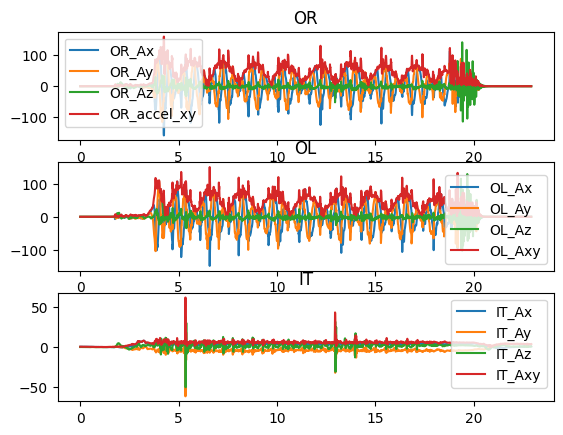

In [9]:
# Plotting raw acceleration data in fixed basis
# ra: raw acceleriations
fig_ra, ax_ra = plt.subplots(3)  # Creates a 3x1 grid of Axes

ax_ra[0].set_title('OR')
ax_ra[0].plot(time, OR_Ax, label='OR_Ax')
ax_ra[0].plot(time, OR_Ay, label='OR_Ay')
ax_ra[0].plot(time, OR_Az, label='OR_Az')
OR_accel_xy = np.sqrt(OR_accel_x**2+OR_accel_y**2)
ax_ra[0].plot(time, OR_accel_xy, label='OR_accel_xy')
ax_ra[0].legend()

ax_ra[1].set_title('OL')
ax_ra[1].plot(time, OL_Ax, label='OL_Ax')
ax_ra[1].plot(time, OL_Ay, label='OL_Ay')
ax_ra[1].plot(time, OL_Az, label='OL_Az')
OL_Axy = np.sqrt(OL_Ax**2+OL_Ay**2)
ax_ra[1].plot(time, OL_Axy, label='OL_Axy')
ax_ra[1].legend()

ax_ra[2].set_title('IT')
ax_ra[2].plot(time, IT_Ax, label='IT_Ax')
ax_ra[2].plot(time, IT_Ay, label='IT_Ay')
ax_ra[2].plot(time, IT_Az, label='IT_Az')
IT_Axy = np.sqrt(IT_Ax**2+IT_Ay**2)
ax_ra[2].plot(time, IT_Axy, label='IT_Axy')
ax_ra[2].legend()

In [10]:
OR_dx, OR_dy, OR_dz, OR_vx, OR_vy, OR_vz = get_position(time,OR_Ax, OR_Ay, OR_Az)
OL_dx, OL_dy, OL_dz, OL_vx, OL_vy, OL_vz = get_position(time,OL_Ax, OL_Ay, OL_Az)
IT_dx, IT_dy, IT_dz, IT_vx, IT_vy, IT_vz = get_position(time,IT_Ax, IT_Ay, IT_Az)


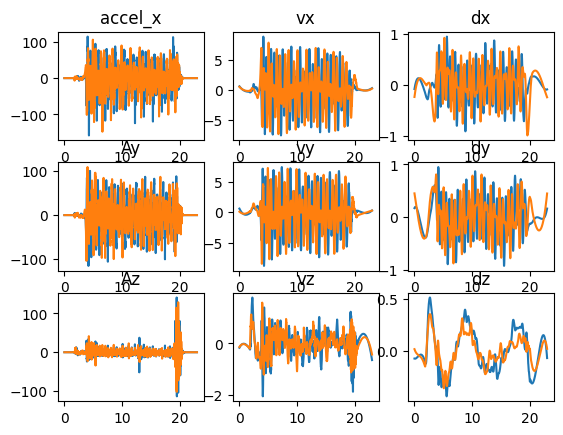

In [11]:
# Plot positions of two points on hoop
fig, ax = plt.subplots(3, 3)  # Creates a 3x1 grid of Axes

# acceleration subplots
ax[0, 0].set_title('accel_x')
ax[0, 0].plot(time, OR_Ax, label='OR_Ax')#, color='blue')
ax[0, 0].plot(time, OL_Ax, label='OL_Ax')#, color='orange')
# ax[0, 0].legend()

ax[1, 0].set_title('Ay')
ax[1, 0].plot(time, OR_Ay)
ax[1, 0].plot(time, OL_Ay)

ax[2, 0].set_title('Az')
ax[2, 0].plot(time, OR_Az)
ax[2, 0].plot(time, OL_Az)

# velocity subplots
ax[0, 1].set_title('vx')
ax[0, 1].plot(time[1:], OR_vx)
ax[0, 1].plot(time[1:], OL_vx)

ax[1, 1].set_title('vy')
ax[1, 1].plot(time[1:], OR_vy)
ax[1, 1].plot(time[1:], OL_vy)

ax[2, 1].set_title('vz')
ax[2, 1].plot(time[1:], OR_vz)
ax[2, 1].plot(time[1:], OL_vz)

# displacement subplots
ax[0, 2].set_title('dx')
ax[0, 2].plot(time[2:], OR_dx)
ax[0, 2].plot(time[2:], OL_dx)

ax[1, 2].set_title('dy')
ax[1, 2].plot(time[2:], OR_dy)
ax[1, 2].plot(time[2:], OL_dy)

ax[2, 2].set_title('dz')
ax[2, 2].plot(time[2:], OR_dz)
ax[2, 2].plot(time[2:], OL_dz)

Text(0.5, 0.92, 'Hoop Sensor Displacement')

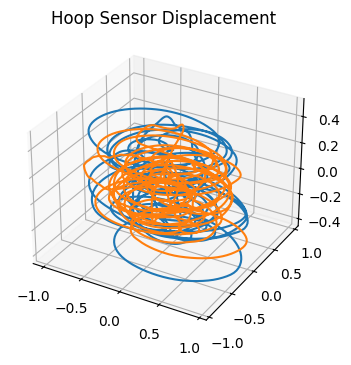

In [12]:
# 3D plot of hoop sensor displacement path

fig_hooppath = plt.figure(figsize=(6,4))
ax = fig_hooppath.add_subplot(projection='3d')
ax.plot(OR_dx,OR_dy,OR_dz)
ax.plot(OL_dx,OL_dy,OL_dz)
ax.set_title('Hoop Sensor Displacement')

Text(0.5, 0.92, 'Hip Sensor Displacement')

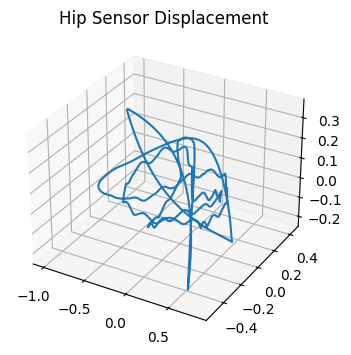

In [13]:
# 3D plot of hip sensor displacement path

fig_hippath = plt.figure(figsize=(6,4))
ax = fig_hippath.add_subplot(projection='3d')
ax.plot(IT_dx,IT_dy,IT_dz)
ax.set_title('Hip Sensor Displacement')

Text(0.5, 0.92, 'All Sensor Displacement Paths')

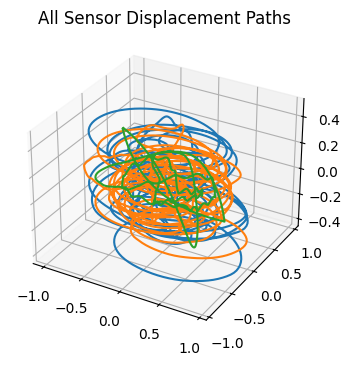

In [14]:
# On same plot

# 3D plot of all sensor displacement paths

fig_paths = plt.figure(figsize=(6,4))
ax = fig_paths.add_subplot(projection='3d')
ax.plot(OR_dx,OR_dy,OR_dz, label='OR_sensor')
ax.plot(OL_dx,OL_dy,OL_dz, label='OR_sensor')
ax.plot(IT_dx,IT_dy,IT_dz, label='IT_sensor')
ax.set_title('All Sensor Displacement Paths')


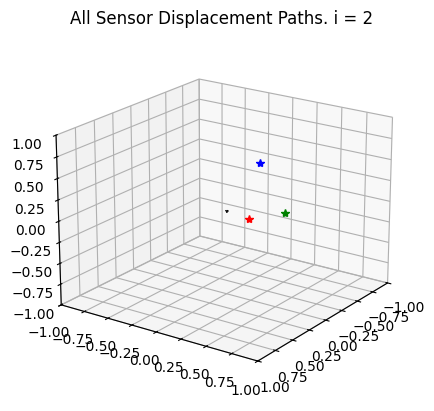

In [15]:
# Animation of sensor location in time

# Set up figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=35)
ax.set_box_aspect([4, 4, 3])  # Adjust for box on

# Fixed basis vectors
ax.quiver(0, 0, 0, 0.01, 0, 0, linewidth=2, color='k')
ax.quiver(0, 0, 0, 0, 0.01, 0, linewidth=2, color='k')
ax.quiver(0, 0, 0, 0, 0, 0.01, linewidth=2, color='k')

ntime = np.size(OR_dx)

# Prepare video writer
writer = FFMpegWriter(fps=round(1/dt)//3)
with writer.saving(fig, "sensor_locations.mp4", dpi=200):

    max_range = 1
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])

    for i in range(2,ntime):

        ax.set_title(f"All Sensor Displacement Paths. i = {i}")

        marker_OR, = ax.plot(OR_dx[i], OR_dy[i], OR_dz[i],
                          marker='*', color='r', linewidth=2)
        marker_OL, = ax.plot(OL_dx[i], OL_dy[i], OL_dz[i],
                          marker='*', color='g', linewidth=2)
        marker_IT, = ax.plot(IT_dx[i], IT_dy[i], IT_dz[i],
                          marker='*', color='b', linewidth=2)

        plt.pause(0.001)
        writer.grab_frame()

        # Remove current frame's artists
        for artist in [marker_OR, marker_OL, marker_IT]:
            artist.remove()

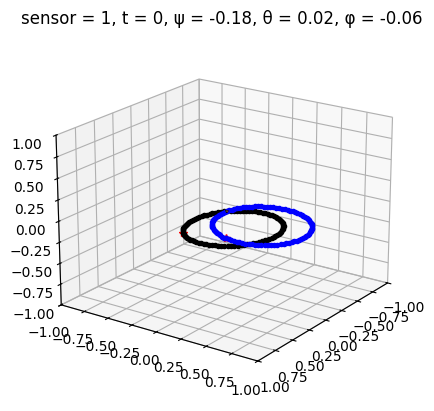

KeyboardInterrupt: 

In [16]:
# Plotting hoop seperately from two sensor data on same plot
colors = ['k','b']

# Set up figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=35)
ax.set_box_aspect([4, 4, 3])  # Adjust for box on

max_range = 1
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range, max_range])

# Fixed basis vectors
ax.quiver(0, 0, 0, 0.01, 0, 0, linewidth=2, color='k')
ax.quiver(0, 0, 0, 0, 0.01, 0, linewidth=2, color='k')
ax.quiver(0, 0, 0, 0, 0, 0.01, linewidth=2, color='k')

delta = np.linspace(0, 2 * np.pi, 100)
xC = np.zeros(3)  # center of hoop

psi = np.vstack((OL_psi, OR_psi)) 
theta = np.vstack((OL_theta, OR_theta)) 
phi = np.vstack((OL_phi, OR_phi)) 

wx = np.vstack((OL_wx, OR_wx)) 
wy = np.vstack((OL_wy, OR_wy)) 
wz = np.vstack((OL_wz, OR_wz)) 

OR_dx_padded = np.concatenate(([0, 0], OR_dx))
OR_dy_padded = np.concatenate(([0, 0], OR_dy))
OR_dz_padded = np.concatenate(([0, 0], OR_dz))
        
OR_vx_padded = np.concatenate(([0], OR_vx))
OR_vy_padded = np.concatenate(([0], OR_vy))
OR_vz_padded = np.concatenate(([0], OR_vz))

OL_dx_padded = np.concatenate(([0, 0], OL_dx))
OL_dy_padded = np.concatenate(([0, 0], OL_dy))
OL_dz_padded = np.concatenate(([0, 0], OL_dz))
        
OL_vx_padded = np.concatenate(([0], OL_vx))
OL_vy_padded = np.concatenate(([0], OL_vy))
OL_vz_padded = np.concatenate(([0], OL_vz))

dx = np.vstack((OR_dx_padded, OL_dx_padded)) 
dy = np.vstack((OR_dy_padded, OL_dy_padded)) 
dz = np.vstack((OR_dz_padded, OL_dz_padded)) 

vx = np.vstack((OR_vx_padded, OL_vx_padded)) 
vy = np.vstack((OR_vy_padded, OL_vy_padded)) 
vz = np.vstack((OR_vz_padded, OL_vz_padded)) 

nsensor = np.shape(psi)[0]
ntime = np.shape(psi)[1]

KE_hoop = np.zeros((nsensor,ntime))
PE_hoop = np.zeros((nsensor,ntime))

exp = np.zeros((3,nsensor,ntime))
eyp = np.zeros((3,nsensor,ntime))
ezp = np.zeros((3,nsensor,ntime))

expp = np.zeros((3,nsensor,ntime))
eypp = np.zeros((3,nsensor,ntime))
ezpp = np.zeros((3,nsensor,ntime))

ex = np.zeros((3,nsensor,ntime))
ey = np.zeros((3,nsensor,ntime))
ez = np.zeros((3,nsensor,ntime))

omega_hoop = np.zeros((3,nsensor,ntime))
vC = np.zeros((3,nsensor,ntime))

mark = [None] * nsensor
hoop = [None] * nsensor

# Prepare video writer
writer = FFMpegWriter(fps=round(1/dt)//3)
with writer.saving(fig, "hula_hoop_two_sensors.mp4", dpi=200):

    for t in range(ntime):

        for s in range(nsensor):
            # s == 0, sensor OR
            # s == 1, sensor OL

            # First rotation by an angle psi about E3
            exp[:,s,t] = np.cos(psi[s,t])*E1+np.sin(psi[s,t])*E2
            eyp[:,s,t] = -np.sin(psi[s,t])*E1+np.cos(psi[s,t])*E2
            ezp[:,s,t] = E3
            # Second rotation by an angle theta about e2p
            expp[:,s,t] = np.cos(theta[s,t])*exp[:,s,t]-np.sin(theta[s,t])*ezp[:,s,t]
            eypp[:,s,t] = eyp[:,s,t]
            ezpp[:,s,t] = np.sin(theta[s,t])*exp[:,s,t]+np.cos(theta[s,t])*ezp[:,s,t]
            # Third rotation by an angle phi about e1pp
            ex[:,s,t] = expp[:,s,t]
            ey[:,s,t] = np.cos(phi[s,t])*eypp[:,s,t]+np.sin(phi[s,t])*ezpp[:,s,t]
            ez[:,s,t] = -np.sin(phi[s,t])*eypp[:,s,t]+np.cos(phi[s,t])*ezpp[:,s,t]

            omega_hoop[:,s,t] = wx[s,t]*ex[:,s,t]+wy[s,t]*ey[:,s,t]+wz[s,t]*ez[:,s,t]

            vC[:,s,t] = np.array([vx[s,t],vy[s,t],vz[s,t]])+np.cross(omega_hoop[:,s,t],r*ey[:,s,t])

            KE_hoop[s,t] = 0.5*(Ixx*wx[s,t]**2+Iyy*wy[s,t]**2+Izz*wz[s,t]**2)+0.5*nsensor*np.linalg.norm(vC[:,s,t])**2
            PE_hoop[s,t] = nsensor*g*dz[s,t]

            ax.set_title(f"sensor = {s}, t = {t}, ψ = {psi[s,t]:.2f}, θ = {theta[s,t]:.2f}, φ = {phi[s,t]:.2f}")

            # Blue vectors
            e1p_plot = ax.quiver(0, 0, 0, *0.01*exp[:,s,t], linewidth=1, color='b')
            e2p_plot = ax.quiver(0, 0, 0, *0.01*eyp[:,s,t], linewidth=1, color='b')
            e3p_plot = ax.quiver(0, 0, 0, *0.01*ezp[:,s,t], linewidth=1, color='b')

            # Red vectors
            e1pp_plot = ax.quiver(0, 0, 0, *0.01*expp[:,s,t], linewidth=1, color='r')
            e2pp_plot = ax.quiver(0, 0, 0, *0.01*eypp[:,s,t], linewidth=1, color='r')
            e3pp_plot = ax.quiver(0, 0, 0, *0.01*ezpp[:,s,t], linewidth=1, color='r')

            # Green vectors
            e1_plot = ax.quiver(0, 0, 0, *0.01*ex[:,s,t], linewidth=1, color='g')
            e2_plot = ax.quiver(0, 0, 0, *0.01*ey[:,s,t], linewidth=1, color='g')
            e3_plot = ax.quiver(0, 0, 0, *0.01*ez[:,s,t], linewidth=1, color='g')


            # Circle
            xCircle = np.zeros((100, 3))
            xC = r*ey[:,s,t]+np.array([dx[s,t],dy[s,t],dz[s,t]])
            for j in range(100):
                xCircle[j, :] = xC + r * (np.cos(delta[j]) * ex[:,s,t] + np.sin(delta[j]) * ey[:,s,t])

            mark[s], = ax.plot([xCircle[0, 0]], [xCircle[0, 1]], [xCircle[0, 2]],
                            marker='*', color='r', linewidth=2)
            hoop[s], = ax.plot(xCircle[:, 0], xCircle[:, 1], xCircle[:, 2],
                            '.', color=colors[s], linewidth=2)

        plt.pause(0.001)
        writer.grab_frame()

        # Remove current frame's artists
        for s in range(nsensor):
            mark[s].remove()
            hoop[s].remove()
        for artist in [e1p_plot, e2p_plot, e3p_plot,
                    e1pp_plot, e2pp_plot, e3pp_plot,
                    e1_plot, e2_plot, e3_plot]:
            artist.remove()

# total energy of hoop
E_hoop = KE_hoop+PE_hoop


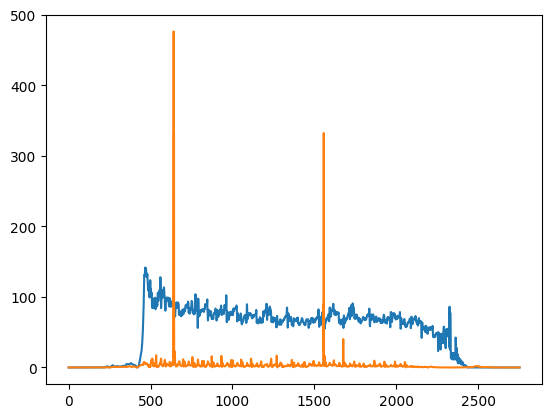

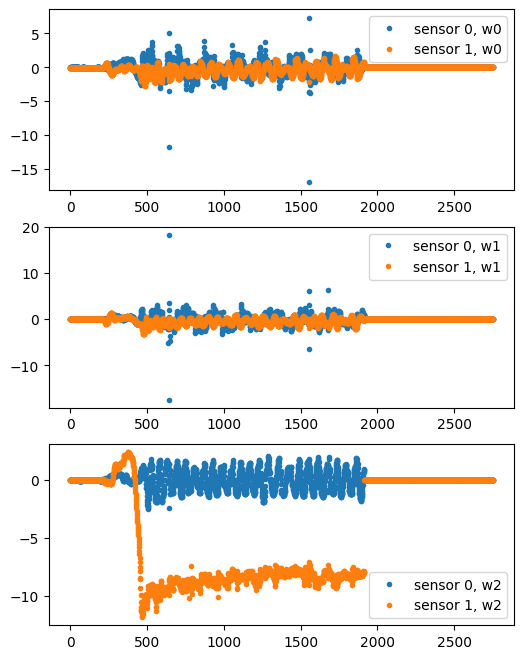

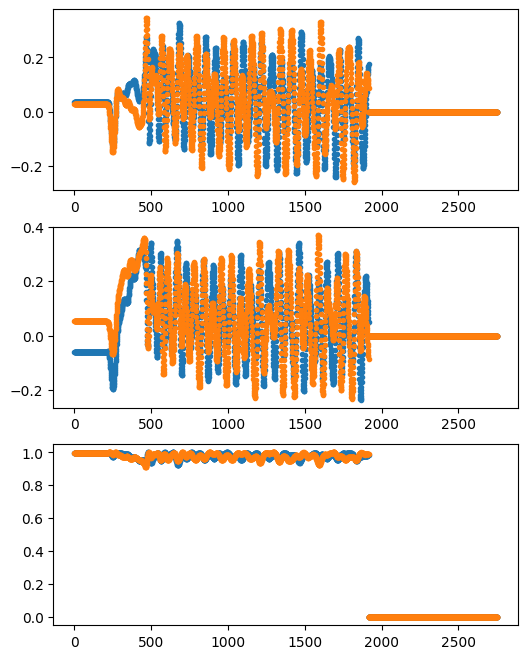

In [24]:
# Comparing data from the two sensors

# Magnitude of angular velocity vector
OR_omega_norm = OR_wx**2+OR_wy**2+OR_wz**2
OL_omega_norm = OL_wx**2+OL_wy**2+OL_wz**2
fig_wnorm, ax_wnorm = plt.subplots()
ax_wnorm.plot(OR_omega_norm)
ax_wnorm.plot(OL_omega_norm)

# Angular velocities
fig_w, ax_w = plt.subplots(3,1,figsize=(6, 8))
for s in range(nsensor):
    for i in range(3):
        ax_w[i].plot(omega_hoop[i,s,:],'.',label=f'sensor {s}, w{i}') 
        ax_w[i].legend()

# Unit vector ez
fig_ez, ax_ez = plt.subplots(3,1,figsize=(6, 8))
for s in range(nsensor):
    for i in range(3):
        ax_ez[i].plot(ez[i,s,:],'.',label=f'sensor {s}, w{i}') 

# Calculating the relative position vector between the two sensors
# https://chatgpt.com/share/687ff75c-b810-8011-bd51-12152ce2bfab

# OL_vx, OL_vy, OL_vz
# OR_vx, OR_vy, OR_vz

r_OL_wrt_OR = np.zeros((3,nsensor,ntime))

for t in range(ntime-1):
    temp1 = np.array([OL_vx[t], OL_vy[t], OL_vz[t]])-np.array([OR_vx[t], OR_vy[t], OR_vz[t]])
    for s in range(nsensor):
        temp2 = np.cross(omega_hoop[:,s,t],temp1)/(np.linalg.norm(temp1)**2)
        temp3 = np.dot(temp1,ez[:,s,t])
        if temp3 != 0:
            k = -np.dot(temp2,ez[:,s,t])/temp3
            r_OL_wrt_OR[:,s,t] = temp2+k*temp1


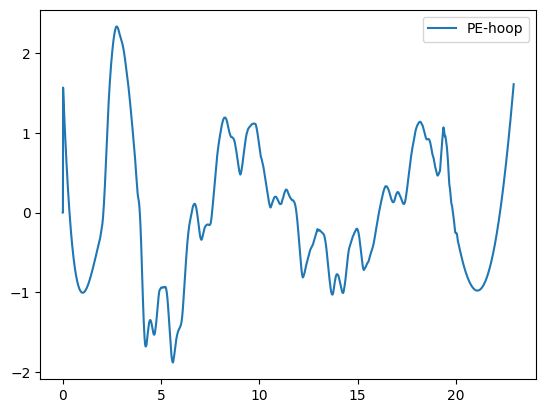

In [34]:
# Plot Energies
fig_E, ax_E = plt.subplots()

# ax_E.plot(time, KE_hoop, label='KE-hoop')
ax_E.plot(time, PE_hoop, label='PE-hoop')
# ax_E.plot(time, E_hoop, label='E-hoop')
ax_E.legend()
